In [8]:
%load_ext autoreload
%autoreload 2
import torch
import torch.utils.data
import numpy as np
import sklearn.datasets
import sklearn.model_selection
import matplotlib.pyplot as plt

import abstract_gradient_training as agt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
"""Initialise the halfmoons training data."""
seed = 0
batchsize = 10000  # number of samples per batch
test_size = 5000
n_users = 1000
n_batches = 1  # number of batches per epoch
n_epochs = 10  # number of epochs

torch.manual_seed(seed)
# load the dataset
x, y = sklearn.datasets.make_moons(noise=0.1, n_samples=n_batches*batchsize + test_size, random_state=seed)
# to make it easier to train, we'll space the moons out a bit and add some polynomial features
x[y==0, 1] += 0.2
x = np.hstack((x, x**2, (x[:, 0] * x[:, 1])[:, None], x**3))


# Train-test split
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    x, y, test_size=test_size / (n_batches * batchsize + test_size), random_state=seed
)


# Assign users randomly to each set after the split
user_train = np.random.randint(1, n_users + 1, size=len(x_train))
user_test = np.random.randint(1, n_users + 1, size=len(x_test))

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
x_test = torch.from_numpy(x_test).float()
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)
user_train = torch.from_numpy(user_train)
user_test = torch.from_numpy(user_test)

# Combine inputs and both labels into TensorDatasets
dataset_train = torch.utils.data.TensorDataset(x_train, user_train, y_train)
dataset_test = torch.utils.data.TensorDataset(x_test, user_test, y_test)

print(y)

# Create DataLoaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batchsize, shuffle=False)



[0 1 1 ... 1 1 0]


In [3]:
privacy_bounded_models = {}
k_private_values = [1, 2, 5, 10, 20, 50, 100] 
for k in k_private_values:
    model = torch.nn.Sequential(
        torch.nn.Linear(7, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 2),
    )
    bounded_model = agt.bounded_models.IntervalBoundedModel(model, trainable=True)
    bounded_model.load_params(f"model_user_10000/500/k_{k}.model")
    privacy_bounded_models[k] = bounded_model

# evaluate the fine-tuned model
dataset_test_all = torch.utils.data.TensorDataset(x_test, y_test)
accuracy = agt.test_metrics.test_accuracy(bounded_model, *dataset_test_all.tensors)
print(f"Fine-tuned model accuracy + certified bounds (all classes): {accuracy[0]:.2f} <= {accuracy[1]:.2f} <= {accuracy[2]:.2f}")

Fine-tuned model accuracy + certified bounds (all classes): 0.00 <= 0.84 <= 1.00


In [4]:
# make privacy-safe predictions using the global sensitivity
epsilon = 1.0
# dataset_test_all = dataset_test
accuracy = agt.privacy_utils.noisy_test_accuracy(
    bounded_model, *dataset_test_all.tensors, noise_level=1 / epsilon, noise_type="laplace"
)
print(f"Accuracy using global sensitivity: {accuracy:.2f}")

# make privacy-safe predictions using the smooth sensitivity bounds from AGT
noise_level = agt.privacy_utils.get_calibrated_noise_level(
    dataset_test_all.tensors[0], privacy_bounded_models, epsilon=epsilon, noise_type="cauchy" 
)
accuracy = agt.privacy_utils.noisy_test_accuracy(
    bounded_model, *dataset_test_all.tensors, noise_level=noise_level, noise_type="cauchy"
)
print(f"Accuracy using AGT smooth sensitivity bounds: {accuracy:.2f}")

Accuracy using global sensitivity: 0.62
Accuracy using AGT smooth sensitivity bounds: 0.58


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

dataset_test = torch.utils.data.TensorDataset(x_test, y_test)

# Define the specific epsilon values
epsilon_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000, 10000000000, 100000000000, 1000000000000]

# Store results for both normal MSE and global sensitivity-based MSE
normal_mse_values = []
global_sensitivity_mse_values = []
no_privacy_mse_values = []

# Loop over epsilon values and calculate the MSE for each
for epsilon in epsilon_values:
    print(epsilon)
    # Calculate the noise level using AGT smooth sensitivity bounds
    noise_level = agt.privacy_utils.get_calibrated_noise_level(
        dataset_test.tensors[0], privacy_bounded_models, epsilon=epsilon, noise_type="cauchy"
    )
    print(noise_level)
    
    ave = 0
    num = 100
    for i in range(num):
        ave += agt.privacy_utils.noisy_test_accuracy(
            privacy_bounded_models[100], *dataset_test.tensors, noise_level=noise_level, noise_type="cauchy"
        )
    acc = ave / (num)
    print(acc)
    # print(f"Average MSE is {ave / (num * len(dataset_test))}")
    
    # Store normal MSE
    normal_mse_values.append(acc)
    

    ave = 0
    num = 100
    for i in range(num):
        ave += agt.privacy_utils.noisy_test_accuracy(
            privacy_bounded_models[100], *dataset_test.tensors, noise_level=6/epsilon, noise_type="cauchy"
        )
    
    global_mse = ave / (num)
    # Store global sensitivity MSE
    global_sensitivity_mse_values.append(acc)

    no_privacy_mse = agt.privacy_utils.noisy_test_accuracy(
            privacy_bounded_models[100], *dataset_test.tensors, noise_level=0, noise_type="none"
        ) 

    # no_privacy_mse = agt.test_metrics.test_accuracy(privacy_bounded_models[1], x_test, y_test)[1]
    # Store global sensitivity MSE
    no_privacy_mse_values.append(no_privacy_mse)



0.001
tensor([5995.0054, 5990.0142, 5990.0142,  ..., 5990.0142, 5990.0142,
        5990.0142], device='cuda:0')
2
0.01
tensor([595.0211, 590.0834, 590.0834,  ..., 590.0834, 590.0834, 590.0834],
       device='cuda:0')
2
0.1
tensor([55.2027, 50.7890, 50.7890,  ..., 50.7890, 50.7890, 50.7890],
       device='cuda:0')
2
1
tensor([2.6076, 1.1333, 1.1333,  ..., 1.1333, 1.1333, 1.1333], device='cuda:0')
2
10
tensor([1.4422e-04, 3.4667e-08, 3.4667e-08,  ..., 3.4667e-08, 3.4667e-08,
        3.4667e-08], device='cuda:0')
2
100
tensor([3.8632e-38, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00], device='cuda:0')
2
1000
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
2
10000
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
2
100000
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
2
1000000
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
2
10000000
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
2
100000000
tensor([0., 0., 0.,  ..., 0

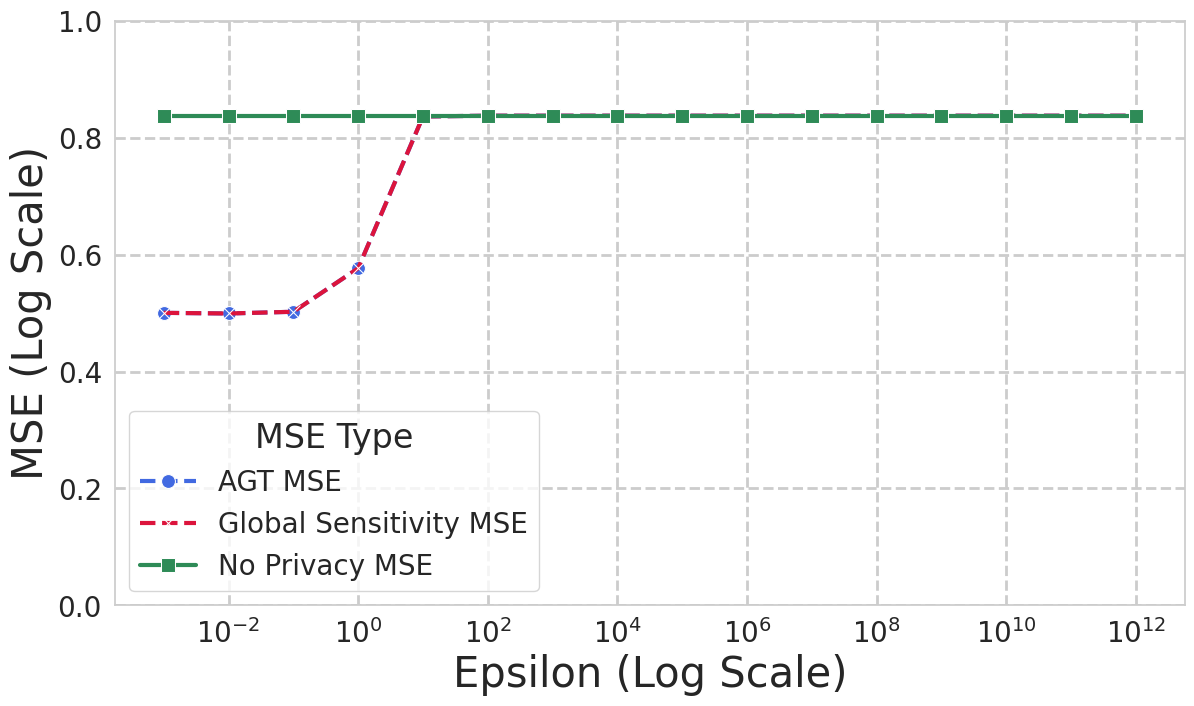

In [23]:
import seaborn as sns
# Apply a Seaborn theme
sns.set_theme(style="whitegrid")

# Create the figure
plt.figure(figsize=(12, 7))

# Plot MSE curves with enhanced styles
sns.lineplot(x=epsilon_values, y=normal_mse_values, label="AGT MSE", 
             marker='o', markersize=10, linestyle='--', color='royalblue', linewidth=3)

sns.lineplot(x=epsilon_values, y=global_sensitivity_mse_values, label="Global Sensitivity MSE", 
             marker='x', markersize=10, linestyle='--', color='crimson', linewidth=3)

sns.lineplot(x=epsilon_values, y=no_privacy_mse_values, label="No Privacy MSE", 
             marker='s', markersize=10, linestyle='-', color='seagreen', linewidth=3)

# sns.lineplot(x=epsilon_values, y=no_privacy_mse_values, label="Laplace Global", 
#              marker='s', markersize=10, linestyle='-', color='black', linewidth=3)


# Log scale for both axes
plt.xscale('log')
# plt.yscale('log')

# Axis labels and title
plt.xlabel('Epsilon (Log Scale)', fontsize=30)
plt.ylabel('MSE (Log Scale)', fontsize=30)
# plt.title('MSE vs Epsilon under Different Privacy Settings', fontsize=16, fontweight='bold')

# Legend and grid
plt.legend(title='MSE Type', fontsize=20, title_fontsize=24, loc='best')
plt.grid(True, which="both", linestyle='--', linewidth=2)

# Tidy up layout
plt.tight_layout()

plt.ylim(0, 1)

plt.tick_params(axis='both', labelsize=20) 

# Show plot
plt.show()